# This is a tutorial of using scDHMap on a simulated dataset

The simulated dataset was generated by "splatter_simulation_dropout.R" with the setting dropout_mid = 2.5.

This tutorial was implemented on Intel(R) Core(TM) i9-10920X CPU @ 3.50GHz and NVIDIA(R) GeForce(TM) RTX 3090 GPU.

Setup parameters.

In [1]:
import math, os
from time import time

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from scDHMap import scDHMap
from embedding_quality_score import get_quality_metrics
import numpy as np
import collections
from sklearn import metrics
from single_cell_tools import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import h5py
import scanpy as sc
from preprocess import read_dataset, normalize, pearson_residuals

In [2]:
torch.set_default_dtype(torch.float64)

In [3]:
'''
Parameter setting
'''

class Args(object):
    def __init__(self):
        self.data_file = 'Splatter_simulate_1.h5'
        self.batch_size = 512
        self.select_genes = 1000
        self.n_PCA = 50
        self.pretrain_iter = 400
        self.maxiter = 5000
        self.minimum_iter = 0
        self.patience = 150
        self.lr = 1e-3
        self.alpha = 1000.
        self.beta = 10.
        self.prob = 0
        self.perplexity = [30.]
        self.ae_weights = None
        self.ae_weights_file = 'AE_weights.pth.tar'
        self.save_dir = 'ES_model/'
        self.pretrain_latent_file = 'ae_latent.txt'
        self.final_latent_file = 'final_latent.txt'
        self.device = 'cuda'
        
args = Args()

Read data. X is the matrix of raw counts, and X_true is the matrix of true counts. True counts are used for evaluating embedding quality here.

In [4]:
data_mat = h5py.File(args.data_file, 'r')
x = np.array(data_mat['X'])
x_true = np.array(data_mat['X_true'])
data_mat.close()

importantGenes = geneSelection(x, n=args.select_genes, plot=False)
x = x[:, importantGenes]
x_true = x_true[:, importantGenes]

# preprocessing scRNA-seq read counts matrix
adata0 = sc.AnnData(x)

adata = read_dataset(adata0,
                 transpose=False,
                 copy=True)

adata = normalize(adata,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

X_normalized = pearson_residuals(x, theta=100)
X_true_normalized = pearson_residuals(x_true, theta=100)

X_pca = PCA(n_components=args.n_PCA, svd_solver='full').fit_transform(X_normalized)
X_true_pca = PCA(n_components=args.n_PCA, svd_solver='full').fit_transform(X_true_normalized)

print(args)

print(x.shape)
print(x_true.shape)
print(X_pca.shape)
print(X_true_pca.shape)

Chosen offset: 2.68
### Autoencoder: Successfully preprocessed 1000 genes and 4000 cells.
(4000, 1000)
(4000, 1000)
(4000, 50)
(4000, 50)


Build the model.

In [5]:
model = scDHMap(input_dim=adata.n_vars, encodeLayer=[128, 64, 32, 16], decodeLayer=[16, 32, 64, 128], 
        batch_size=args.batch_size, activation="elu", z_dim=2, alpha=args.alpha, beta=args.beta, 
        perplexity=args.perplexity, prob=args.prob, device=args.device).to(args.device)

print(str(model))

scDHMap(
  (encoder): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ELU(alpha=1.0)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4

Pretrain the model.

In [6]:
'''
Pretrain model
'''
t0 = time()
if args.ae_weights is None:
    model.pretrain_autoencoder(adata.X.astype(np.float64), adata.raw.X.astype(np.float64), adata.obs.size_factors.astype(np.float64), 
        lr=args.lr, pretrain_iter=args.pretrain_iter, ae_save=True, ae_weights=args.ae_weights_file)
else:
    if os.path.isfile(args.ae_weights):
        print("==> loading checkpoint '{}'".format(args.ae_weights))
        checkpoint = torch.load(args.ae_weights)
        model.load_state_dict(checkpoint['ae_state_dict'])
    else:
        print("==> no checkpoint found at '{}'".format(args.ae_weights))
        raise ValueError
print('Pretraining time: %d seconds.' % int(time() - t0))

Pretraining stage
Pretraining epoch 1, Total loss:24991.11034161, ZINB loss:24990.40995320, KLD loss:0.70038841
Pretraining epoch 2, Total loss:20621.25077916, ZINB loss:20620.58375651, KLD loss:0.66702265
Pretraining epoch 3, Total loss:16309.71621443, ZINB loss:16309.11781040, KLD loss:0.59840402
Pretraining epoch 4, Total loss:12347.25070288, ZINB loss:12346.69805099, KLD loss:0.55265189
Pretraining epoch 5, Total loss:9497.15275886, ZINB loss:9496.61776255, KLD loss:0.53499631
Pretraining epoch 6, Total loss:7508.73522812, ZINB loss:7508.19868655, KLD loss:0.53654156
Pretraining epoch 7, Total loss:6287.28862639, ZINB loss:6286.76608947, KLD loss:0.52253692
Pretraining epoch 8, Total loss:5522.74270627, ZINB loss:5522.18639678, KLD loss:0.55630949
Pretraining epoch 9, Total loss:5049.28562978, ZINB loss:5048.74291426, KLD loss:0.54271552
Pretraining epoch 10, Total loss:4741.82782061, ZINB loss:4741.28990854, KLD loss:0.53791207
Pretraining epoch 11, Total loss:4545.81664625, ZINB 

Pretraining epoch 90, Total loss:3341.71839624, ZINB loss:3340.97071598, KLD loss:0.74768027
Pretraining epoch 91, Total loss:3334.13048839, ZINB loss:3333.36108908, KLD loss:0.76939932
Pretraining epoch 92, Total loss:3333.83124667, ZINB loss:3333.07603333, KLD loss:0.75521335
Pretraining epoch 93, Total loss:3329.55768732, ZINB loss:3328.78551324, KLD loss:0.77217408
Pretraining epoch 94, Total loss:3325.82196530, ZINB loss:3325.04076417, KLD loss:0.78120112
Pretraining epoch 95, Total loss:3319.12715026, ZINB loss:3318.33164377, KLD loss:0.79550650
Pretraining epoch 96, Total loss:3313.55202690, ZINB loss:3312.75783626, KLD loss:0.79419064
Pretraining epoch 97, Total loss:3309.89383548, ZINB loss:3309.09533843, KLD loss:0.79849705
Pretraining epoch 98, Total loss:3313.88946357, ZINB loss:3313.08450471, KLD loss:0.80495886
Pretraining epoch 99, Total loss:3309.48970454, ZINB loss:3308.67232774, KLD loss:0.81737680
Pretraining epoch 100, Total loss:3306.05766476, ZINB loss:3305.235947

Pretraining epoch 179, Total loss:3115.45689739, ZINB loss:3114.02885595, KLD loss:1.42804144
Pretraining epoch 180, Total loss:3114.26571627, ZINB loss:3112.79981686, KLD loss:1.46589941
Pretraining epoch 181, Total loss:3109.61727379, ZINB loss:3108.20850638, KLD loss:1.40876741
Pretraining epoch 182, Total loss:3108.77490819, ZINB loss:3107.30278355, KLD loss:1.47212463
Pretraining epoch 183, Total loss:3109.92872635, ZINB loss:3108.45982827, KLD loss:1.46889808
Pretraining epoch 184, Total loss:3111.81026141, ZINB loss:3110.31623255, KLD loss:1.49402886
Pretraining epoch 185, Total loss:3108.86889426, ZINB loss:3107.40418613, KLD loss:1.46470812
Pretraining epoch 186, Total loss:3109.83077690, ZINB loss:3108.31617664, KLD loss:1.51460026
Pretraining epoch 187, Total loss:3104.61935988, ZINB loss:3103.11171820, KLD loss:1.50764168
Pretraining epoch 188, Total loss:3105.59159509, ZINB loss:3104.07149634, KLD loss:1.52009875
Pretraining epoch 189, Total loss:3102.34841627, ZINB loss:3

Pretraining epoch 268, Total loss:3028.96409766, ZINB loss:3026.73966765, KLD loss:2.22443001
Pretraining epoch 269, Total loss:3025.90019759, ZINB loss:3023.63776393, KLD loss:2.26243366
Pretraining epoch 270, Total loss:3026.84912486, ZINB loss:3024.58491406, KLD loss:2.26421080
Pretraining epoch 271, Total loss:3027.14663003, ZINB loss:3024.88611138, KLD loss:2.26051866
Pretraining epoch 272, Total loss:3023.33740554, ZINB loss:3021.03932530, KLD loss:2.29808024
Pretraining epoch 273, Total loss:3024.07280622, ZINB loss:3021.77631019, KLD loss:2.29649603
Pretraining epoch 274, Total loss:3022.78705742, ZINB loss:3020.48506541, KLD loss:2.30199202
Pretraining epoch 275, Total loss:3021.21729048, ZINB loss:3018.91076566, KLD loss:2.30652482
Pretraining epoch 276, Total loss:3021.81217126, ZINB loss:3019.47811836, KLD loss:2.33405290
Pretraining epoch 277, Total loss:3020.40301409, ZINB loss:3018.07299309, KLD loss:2.33002100
Pretraining epoch 278, Total loss:3018.48260150, ZINB loss:3

Pretraining epoch 357, Total loss:2980.37262135, ZINB loss:2977.35812140, KLD loss:3.01449995
Pretraining epoch 358, Total loss:2979.46341610, ZINB loss:2976.48030505, KLD loss:2.98311105
Pretraining epoch 359, Total loss:2979.76888379, ZINB loss:2976.75518337, KLD loss:3.01370042
Pretraining epoch 360, Total loss:2979.77536658, ZINB loss:2976.79425775, KLD loss:2.98110883
Pretraining epoch 361, Total loss:2979.08721828, ZINB loss:2976.08742633, KLD loss:2.99979195
Pretraining epoch 362, Total loss:2979.82064514, ZINB loss:2976.78901541, KLD loss:3.03162973
Pretraining epoch 363, Total loss:2980.12496804, ZINB loss:2977.09489984, KLD loss:3.03006819
Pretraining epoch 364, Total loss:2976.56706062, ZINB loss:2973.48576688, KLD loss:3.08129373
Pretraining epoch 365, Total loss:2976.84980518, ZINB loss:2973.76189362, KLD loss:3.08791155
Pretraining epoch 366, Total loss:2976.51448567, ZINB loss:2973.44912819, KLD loss:3.06535749
Pretraining epoch 367, Total loss:2976.58619149, ZINB loss:2

In [7]:
ae_latent = model.encodeBatch(torch.tensor(adata.X).double().to(args.device)).data.cpu().numpy()
QM_ae = get_quality_metrics(X_true_pca, ae_latent, distance='P')

np.savetxt(args.pretrain_latent_file, ae_latent, delimiter=",")

Poincaré space
Ranking: time = 1.7 sec
Rank high
Ranking: time = 1.7 sec
Rank low
Co-ranking: time = 12.93 sec
Qlocal = 0.39, Qglobal = 0.74, Kmax = 694
Time = 5.86 sec


Train the model with the t-SNE regularization.

In [8]:
'''
Train model with TSNE
'''
t0 = time()
model.train_model(adata.X.astype(np.float64), adata.raw.X.astype(np.float64), adata.obs.size_factors.astype(np.float64), X_pca.astype(np.float64), X_true_pca.astype(np.float64),
                lr=args.lr, maxiter=args.maxiter, minimum_iter=args.minimum_iter,
                patience=args.patience, save_dir=args.save_dir)
print('Training time: %d seconds.' % int(time() - t0))

Training...
Training epoch 1, Total loss:8733.59499683, ZINB loss:3036.49388114, t-SNE loss:5.66488301, KLD loss:3.22181091
Training epoch 2, Total loss:8589.58617070, ZINB loss:2985.80204060, t-SNE loss:5.57202763, KLD loss:3.17565041
Training epoch 3, Total loss:8517.81197107, ZINB loss:2965.71141447, t-SNE loss:5.51950645, KLD loss:3.25941036
Training epoch 4, Total loss:8462.13828886, ZINB loss:2952.14660305, t-SNE loss:5.47519005, KLD loss:3.48016326
Training epoch 5, Total loss:8417.29514727, ZINB loss:2946.24699960, t-SNE loss:5.43382321, KLD loss:3.72249390
Training epoch 6, Total loss:8377.61083363, ZINB loss:2940.74978875, t-SNE loss:5.39728685, KLD loss:3.95741962
Training epoch 7, Total loss:8334.88529848, ZINB loss:2932.34531181, t-SNE loss:5.36032667, KLD loss:4.22133148
Training epoch 8, Total loss:8314.55817738, ZINB loss:2935.65522927, t-SNE loss:5.33388764, KLD loss:4.50153037
Training epoch 9, Total loss:8290.38192069, ZINB loss:2930.14897001, t-SNE loss:5.31314096, 

Training epoch 72, Total loss:8082.33183049, ZINB loss:2855.86409750, t-SNE loss:5.16052774, KLD loss:6.59399902
Training epoch 73, Total loss:8084.42109492, ZINB loss:2856.65951182, t-SNE loss:5.16204901, KLD loss:6.57125746
Training epoch 74, Total loss:8087.59733234, ZINB loss:2860.57129754, t-SNE loss:5.16157335, KLD loss:6.54526844
Training epoch 75, Total loss:8087.26928204, ZINB loss:2857.77954418, t-SNE loss:5.16385469, KLD loss:6.56350442
Training epoch 76, Total loss:8083.95137449, ZINB loss:2854.40520803, t-SNE loss:5.16390606, KLD loss:6.56401084
Training epoch 77, Total loss:8092.52569383, ZINB loss:2862.19288960, t-SNE loss:5.16518386, KLD loss:6.51489400
Training epoch 78, Total loss:8084.62180273, ZINB loss:2855.33536218, t-SNE loss:5.16376152, KLD loss:6.55249245
Training epoch 79, Total loss:8082.08100336, ZINB loss:2855.17503161, t-SNE loss:5.16182993, KLD loss:6.50760402
Training epoch 80, Total loss:8084.26262933, ZINB loss:2857.08439375, t-SNE loss:5.16108114, KLD

Training epoch 142, Total loss:8058.58148196, ZINB loss:2835.38341215, t-SNE loss:5.15305535, KLD loss:7.01427234
Training epoch 143, Total loss:8055.59164549, ZINB loss:2836.70590899, t-SNE loss:5.14826884, KLD loss:7.06168994
Training epoch 144, Total loss:8052.60788863, ZINB loss:2831.65620517, t-SNE loss:5.15034908, KLD loss:7.06026064
Training epoch 145, Total loss:8048.95917996, ZINB loss:2829.50191010, t-SNE loss:5.14902230, KLD loss:7.04349656
Training epoch 146, Total loss:8054.63900379, ZINB loss:2834.31004833, t-SNE loss:5.14999903, KLD loss:7.03299236
Training epoch 147, Total loss:8053.38022639, ZINB loss:2834.00521392, t-SNE loss:5.14932335, KLD loss:7.00516623
Training epoch 148, Total loss:8059.55735669, ZINB loss:2838.18652982, t-SNE loss:5.15087232, KLD loss:7.04985029
Training epoch 149, Total loss:8066.70895063, ZINB loss:2846.36144596, t-SNE loss:5.15049517, KLD loss:6.98523353
Training epoch 150, Total loss:8060.58622625, ZINB loss:2841.14729914, t-SNE loss:5.1492

Training epoch 211, Total loss:8035.05721186, ZINB loss:2820.12123777, t-SNE loss:5.14245909, KLD loss:7.24768833
Training epoch 212, Total loss:8039.26686189, ZINB loss:2824.28283731, t-SNE loss:5.14192725, KLD loss:7.30567794
Training epoch 213, Total loss:8040.02560612, ZINB loss:2824.90609670, t-SNE loss:5.14193408, KLD loss:7.31854259
Training epoch 214, Total loss:8037.73806754, ZINB loss:2822.72158196, t-SNE loss:5.14241925, KLD loss:7.25972349
Training epoch 215, Total loss:8039.64494253, ZINB loss:2824.08058704, t-SNE loss:5.14250973, KLD loss:7.30546278
Training epoch 216, Total loss:8032.61330717, ZINB loss:2817.80807742, t-SNE loss:5.14162800, KLD loss:7.31772292
Training epoch 217, Total loss:8030.28921189, ZINB loss:2817.44670758, t-SNE loss:5.14018271, KLD loss:7.26597949
Training epoch 218, Total loss:8033.98691943, ZINB loss:2817.88050763, t-SNE loss:5.14281045, KLD loss:7.32959649
Training epoch 219, Total loss:8032.81084415, ZINB loss:2819.41339315, t-SNE loss:5.1405

Ranking: time = 1.8 sec
Rank high
Ranking: time = 1.7 sec
Rank low
Co-ranking: time = 13.06 sec
Qlocal = 0.61, Qglobal = 0.82, Kmax = 253
Time = 5.91 sec
Training epoch 282, Total loss:8034.68364682, ZINB loss:2819.85888504, t-SNE loss:5.14119987, KLD loss:7.36248897
Training epoch 283, Total loss:8034.81541903, ZINB loss:2820.22985714, t-SNE loss:5.14117100, KLD loss:7.34145648
Training epoch 284, Total loss:8033.47456471, ZINB loss:2819.12783806, t-SNE loss:5.14048959, KLD loss:7.38571366
Training epoch 285, Total loss:8031.26286188, ZINB loss:2815.54453917, t-SNE loss:5.14109848, KLD loss:7.46198448
Training epoch 286, Total loss:8025.21388340, ZINB loss:2812.82753922, t-SNE loss:5.13868072, KLD loss:7.37056218
Training epoch 287, Total loss:8027.43583621, ZINB loss:2813.50642318, t-SNE loss:5.14037959, KLD loss:7.35498219
Training epoch 288, Total loss:8027.15433510, ZINB loss:2813.00319322, t-SNE loss:5.13999221, KLD loss:7.41589301
Training epoch 289, Total loss:8027.72048551, ZI

Training epoch 352, Total loss:8023.16580715, ZINB loss:2810.03138986, t-SNE loss:5.13809180, KLD loss:7.50426203
Training epoch 353, Total loss:8025.40936557, ZINB loss:2811.20899377, t-SNE loss:5.13919819, KLD loss:7.50021862
Training epoch 354, Total loss:8027.64319972, ZINB loss:2813.16816233, t-SNE loss:5.14012994, KLD loss:7.43450973
Training epoch 355, Total loss:8022.29935194, ZINB loss:2809.78696645, t-SNE loss:5.13770871, KLD loss:7.48036762
Training epoch 356, Total loss:8023.74831816, ZINB loss:2811.58794613, t-SNE loss:5.13742940, KLD loss:7.47309749
Training epoch 357, Total loss:8023.44671147, ZINB loss:2811.40310510, t-SNE loss:5.13710246, KLD loss:7.49411426
Training epoch 358, Total loss:8023.89592287, ZINB loss:2811.19284562, t-SNE loss:5.13746617, KLD loss:7.52369119
Training epoch 359, Total loss:8022.98068701, ZINB loss:2808.63399014, t-SNE loss:5.13966057, KLD loss:7.46861254
Training epoch 360, Total loss:8023.53352452, ZINB loss:2810.66192656, t-SNE loss:5.1383

Training epoch 421, Total loss:8023.52041212, ZINB loss:2807.57960099, t-SNE loss:5.14012466, KLD loss:7.58161481
Training epoch 422, Total loss:8023.27236785, ZINB loss:2809.97919433, t-SNE loss:5.13795596, KLD loss:7.53372088
Training epoch 423, Total loss:8023.27372826, ZINB loss:2809.17845276, t-SNE loss:5.13899957, KLD loss:7.50957072
Training epoch 424, Total loss:8018.86608014, ZINB loss:2806.91665512, t-SNE loss:5.13664181, KLD loss:7.53076120
Training epoch 425, Total loss:8021.52496716, ZINB loss:2807.47160343, t-SNE loss:5.13847990, KLD loss:7.55734625
Training epoch 426, Total loss:8018.46400987, ZINB loss:2806.12641523, t-SNE loss:5.13697538, KLD loss:7.53622154
Training epoch 427, Total loss:8022.20920717, ZINB loss:2808.48804721, t-SNE loss:5.13865673, KLD loss:7.50644347
Training epoch 428, Total loss:8023.38442931, ZINB loss:2809.52724793, t-SNE loss:5.13867764, KLD loss:7.51795417
Training epoch 429, Total loss:8019.68081633, ZINB loss:2807.51646921, t-SNE loss:5.1366

Training epoch 490, Total loss:8016.67766533, ZINB loss:2803.24171560, t-SNE loss:5.13735370, KLD loss:7.60822496
Training epoch 491, Total loss:8019.04393221, ZINB loss:2805.42176725, t-SNE loss:5.13799577, KLD loss:7.56263990
Training epoch 492, Total loss:8018.59405281, ZINB loss:2806.66308850, t-SNE loss:5.13639593, KLD loss:7.55350354
Training epoch 493, Total loss:8017.44157791, ZINB loss:2804.17695750, t-SNE loss:5.13715039, KLD loss:7.61142312
Training epoch 494, Total loss:8015.73909259, ZINB loss:2804.09441601, t-SNE loss:5.13632458, KLD loss:7.53200966
Training epoch 495, Total loss:8016.64157053, ZINB loss:2804.20585500, t-SNE loss:5.13684448, KLD loss:7.55912312
Training epoch 496, Total loss:8017.27821541, ZINB loss:2804.28558330, t-SNE loss:5.13707735, KLD loss:7.59152855
Training epoch 497, Total loss:8014.86637481, ZINB loss:2803.58127402, t-SNE loss:5.13509905, KLD loss:7.61860505
Training epoch 498, Total loss:8016.04819554, ZINB loss:2803.94992374, t-SNE loss:5.1361

Training epoch 561, Total loss:8014.10230379, ZINB loss:2802.26290452, t-SNE loss:5.13605640, KLD loss:7.57830009
Poincaré space
Ranking: time = 1.7 sec
Rank high
Ranking: time = 1.7 sec
Rank low
Co-ranking: time = 12.53 sec
Qlocal = 0.63, Qglobal = 0.82, Kmax = 261
Time = 5.76 sec
Training epoch 562, Total loss:8014.48039556, ZINB loss:2802.34320541, t-SNE loss:5.13548118, KLD loss:7.66560146
Training epoch 563, Total loss:8013.15069243, ZINB loss:2802.09758371, t-SNE loss:5.13500282, KLD loss:7.60502912
Training epoch 564, Total loss:8015.11927598, ZINB loss:2802.99240201, t-SNE loss:5.13564494, KLD loss:7.64819305
Training epoch 565, Total loss:8015.35686973, ZINB loss:2802.87067421, t-SNE loss:5.13641123, KLD loss:7.60749623
Training epoch 566, Total loss:8015.48469267, ZINB loss:2802.53952931, t-SNE loss:5.13657901, KLD loss:7.63661560
Training epoch 567, Total loss:8015.71994319, ZINB loss:2803.48340655, t-SNE loss:5.13581777, KLD loss:7.64187631
Training epoch 568, Total loss:80

Training epoch 630, Total loss:8013.75146078, ZINB loss:2802.15590141, t-SNE loss:5.13499288, KLD loss:7.66026788
Training epoch 631, Total loss:8012.75785369, ZINB loss:2801.56707320, t-SNE loss:5.13499508, KLD loss:7.61957030
Training epoch 632, Total loss:8014.75207831, ZINB loss:2802.11198639, t-SNE loss:5.13612821, KLD loss:7.65118775
Training epoch 633, Total loss:8015.01205938, ZINB loss:2801.63212969, t-SNE loss:5.13663888, KLD loss:7.67410463
Training epoch 634, Total loss:8012.91579651, ZINB loss:2800.73177415, t-SNE loss:5.13567553, KLD loss:7.65084961
Training epoch 635, Total loss:8013.75452251, ZINB loss:2801.86081415, t-SNE loss:5.13560006, KLD loss:7.62936507
Training epoch 636, Total loss:8014.33837464, ZINB loss:2801.80477327, t-SNE loss:5.13583704, KLD loss:7.66965574
Training epoch 637, Total loss:8016.80724833, ZINB loss:2802.89015064, t-SNE loss:5.13781025, KLD loss:7.61068504
Training epoch 638, Total loss:8012.64756366, ZINB loss:2800.62289439, t-SNE loss:5.1356

Training epoch 699, Total loss:8015.79286292, ZINB loss:2803.16489566, t-SNE loss:5.13621495, KLD loss:7.64130148
Training epoch 700, Total loss:8013.80525686, ZINB loss:2802.11172453, t-SNE loss:5.13521935, KLD loss:7.64741869
Training epoch 701, Total loss:8010.07842404, ZINB loss:2799.27918684, t-SNE loss:5.13406682, KLD loss:7.67324197
Training epoch 702, Total loss:8014.47371206, ZINB loss:2800.58361650, t-SNE loss:5.13750503, KLD loss:7.63850612
Training epoch 703, Total loss:8015.15476531, ZINB loss:2802.50318438, t-SNE loss:5.13625928, KLD loss:7.63923045
Training epoch 704, Total loss:8012.66227400, ZINB loss:2800.42950573, t-SNE loss:5.13557580, KLD loss:7.66569717
Training epoch 705, Total loss:8014.85524308, ZINB loss:2802.61798295, t-SNE loss:5.13539688, KLD loss:7.68403804
Training epoch 706, Total loss:8014.25703296, ZINB loss:2801.43595725, t-SNE loss:5.13612545, KLD loss:7.66956305
Training epoch 707, Total loss:8011.82442081, ZINB loss:2800.07142414, t-SNE loss:5.1350

Training epoch 768, Total loss:8013.05269170, ZINB loss:2800.76868527, t-SNE loss:5.13530674, KLD loss:7.69772702
Training epoch 769, Total loss:8011.02728746, ZINB loss:2799.70236738, t-SNE loss:5.13459379, KLD loss:7.67311278
Training epoch 770, Total loss:8012.30863667, ZINB loss:2799.50770429, t-SNE loss:5.13580198, KLD loss:7.69989490
Training epoch 771, Total loss:8011.00721858, ZINB loss:2799.77365633, t-SNE loss:5.13437685, KLD loss:7.68567137
Training epoch 772, Total loss:8011.02635912, ZINB loss:2799.33592644, t-SNE loss:5.13473562, KLD loss:7.69548091
Training epoch 773, Total loss:8011.72907902, ZINB loss:2800.89843271, t-SNE loss:5.13413821, KLD loss:7.66924321
Training epoch 774, Total loss:8012.52560300, ZINB loss:2799.73423250, t-SNE loss:5.13564773, KLD loss:7.71436420
Training epoch 775, Total loss:8013.60353911, ZINB loss:2802.57060575, t-SNE loss:5.13452811, KLD loss:7.65048246
Training epoch 776, Total loss:8012.10836363, ZINB loss:2800.72217525, t-SNE loss:5.1345

Training epoch 839, Total loss:8011.27731036, ZINB loss:2798.96172702, t-SNE loss:5.13524257, KLD loss:7.70730175
Training epoch 840, Total loss:8011.15555458, ZINB loss:2799.31829449, t-SNE loss:5.13437301, KLD loss:7.74642493
Training epoch 841, Total loss:8010.92116703, ZINB loss:2799.75486012, t-SNE loss:5.13418020, KLD loss:7.69861058
Poincaré space
Ranking: time = 1.8 sec
Rank high
Ranking: time = 1.7 sec
Rank low
Co-ranking: time = 12.95 sec
Qlocal = 0.62, Qglobal = 0.82, Kmax = 241
Time = 5.78 sec
Training epoch 842, Total loss:8013.40729930, ZINB loss:2800.36434210, t-SNE loss:5.13575816, KLD loss:7.72847951
Training epoch 843, Total loss:8011.70050632, ZINB loss:2799.37207978, t-SNE loss:5.13517785, KLD loss:7.71505755
Training epoch 844, Total loss:8013.09296565, ZINB loss:2799.41648109, t-SNE loss:5.13630360, KLD loss:7.73728855
Training epoch 845, Total loss:8010.04187373, ZINB loss:2799.66594979, t-SNE loss:5.13347414, KLD loss:7.69017861
Training epoch 846, Total loss:80

Training epoch 908, Total loss:8011.14768371, ZINB loss:2799.07398857, t-SNE loss:5.13454751, KLD loss:7.75261871
Training epoch 909, Total loss:8006.50872868, ZINB loss:2796.00820109, t-SNE loss:5.13323916, KLD loss:7.72613663
Training epoch 910, Total loss:8008.36803455, ZINB loss:2796.91293845, t-SNE loss:5.13373509, KLD loss:7.77200024
Training epoch 911, Total loss:8007.40844183, ZINB loss:2797.17675870, t-SNE loss:5.13317986, KLD loss:7.70518228
Training epoch 912, Total loss:8010.06159103, ZINB loss:2798.14518813, t-SNE loss:5.13476039, KLD loss:7.71560109
Training epoch 913, Total loss:8009.73919539, ZINB loss:2798.41738152, t-SNE loss:5.13423624, KLD loss:7.70855732
Training epoch 914, Total loss:8008.78421335, ZINB loss:2797.39168988, t-SNE loss:5.13397722, KLD loss:7.74153058
Training epoch 915, Total loss:8009.38327547, ZINB loss:2797.37865053, t-SNE loss:5.13455692, KLD loss:7.74477088
Training epoch 916, Total loss:8008.59518996, ZINB loss:2796.57422279, t-SNE loss:5.1345

In [9]:
final_latent = model.encodeBatch(torch.tensor(adata.X).double().to(args.device)).data.cpu().numpy()
QM_ae = get_quality_metrics(X_true_pca, final_latent, distance='P')

np.savetxt(args.final_latent_file, final_latent, delimiter=",")

Poincaré space
Ranking: time = 1.7 sec
Rank high
Ranking: time = 1.7 sec
Rank low
Co-ranking: time = 12.49 sec
Qlocal = 0.62, Qglobal = 0.82, Kmax = 246
Time = 5.71 sec


## Plot embedding in R

Plot the embedding after pretrain.

In [1]:
rm(list = ls())
library(ggplot2)
library(ggforce)

In [2]:
load("./True_trajectory_1.RData")

colorvector <- c("#e6194b", "#3cb44b", "#ffe119", "#0082c8", 
                 "#f58231", "#911eb4", "#46f0f0", "#f032e6",
                 "#d2f53c", "#fabebe", "#008080", "#e6beff",
                 "#aa6e28", "#fffac8", "#800000", "#aaffc3")

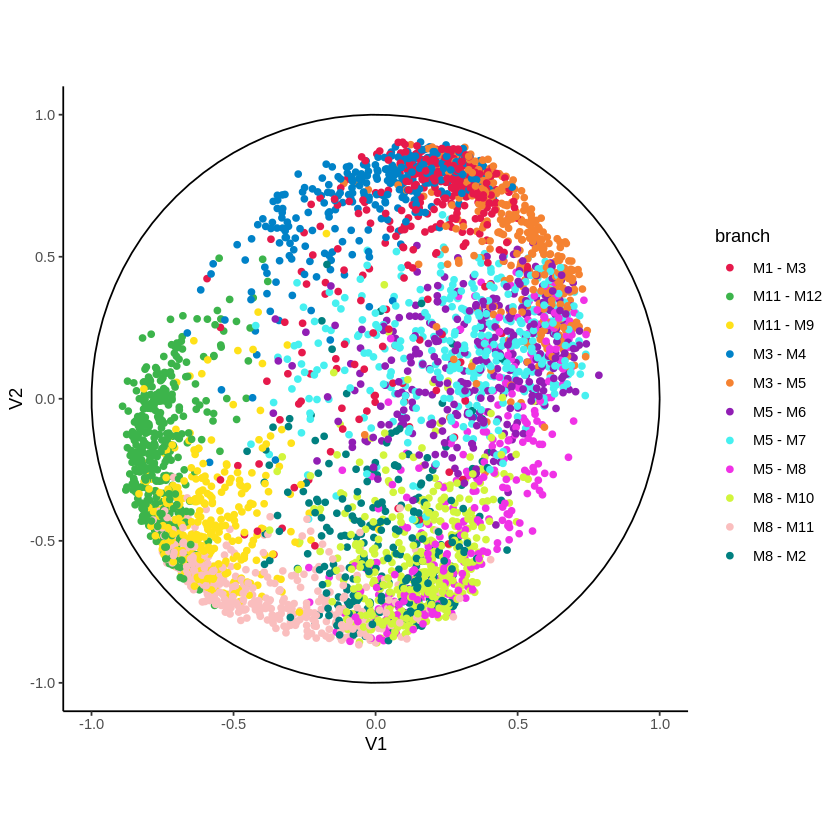

In [3]:
###########################
# Draw pretrain embedding 
###########################
latent <- read.table("ae_latent.txt", sep=",")
dat <- data.frame(latent, branch=paste(progressions$from, progressions$to, sep=" - "))
ggplot(dat, aes(x=V1, y=V2, color=branch)) + geom_point() + 
        annotate("path", x=0+1*cos(seq(0,2*pi,length.out=100)),
                  y=0+1*sin(seq(0,2*pi,length.out=100))) +  
        theme_classic() + coord_fixed(ratio = 1) + scale_color_manual(values=colorvector)

Plot the embedding after training with the t-SNE regularization. We observed that after pretraining, branches were mixed togethor, but adding the t-SNE regularization can clearly differentiate branch structures.

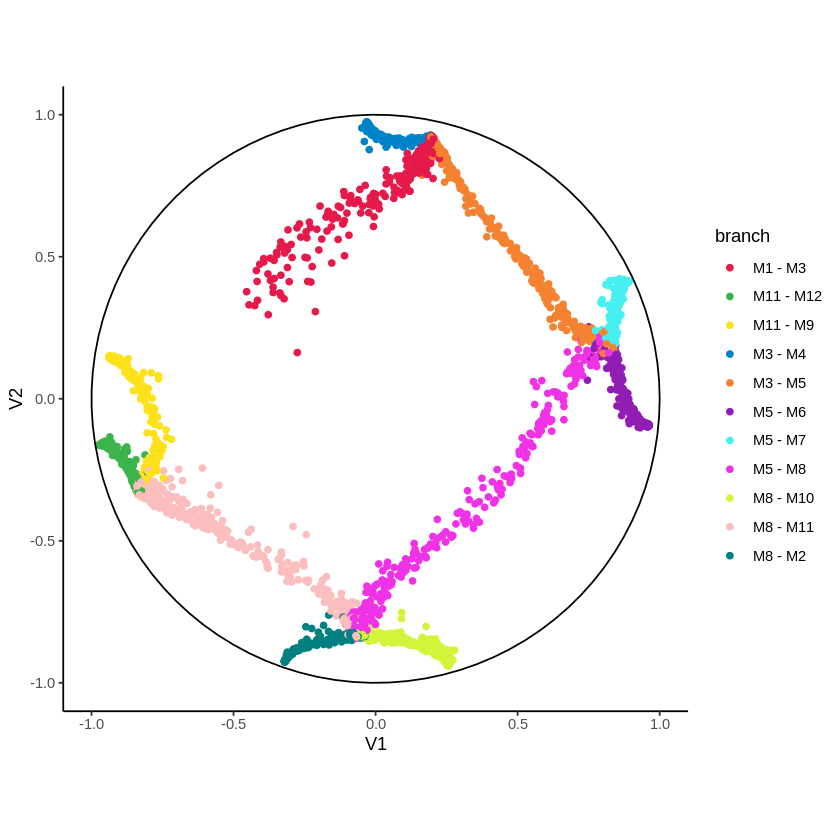

In [4]:
###########################
# Draw final embedding 
###########################
latent <- read.table("final_latent.txt", sep=",")
dat <- data.frame(latent, branch=paste(progressions$from, progressions$to, sep=" - "))
ggplot(dat, aes(x=V1, y=V2, color=branch)) + geom_point() + 
        annotate("path", x=0+1*cos(seq(0,2*pi,length.out=100)),
                         y=0+1*sin(seq(0,2*pi,length.out=100))) +
        theme_classic() + coord_fixed(ratio = 1) + scale_color_manual(values=colorvector)